In [271]:
from itertools import chain, zip_longest
from ucimlrepo import fetch_ucirepo 
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load Data

In [272]:
# fetch dataset 
iris = fetch_ucirepo(id=53) 
# data (as pandas dataframes) 
X = iris.data.features 
y = iris.data.targets 

## Probability Density Function for a Normal Distribution

In [273]:
def pdf_normal(x, axis=0):
    mean, std = np.mean(np.array(x), axis=axis), np.std(np.array(x), axis=axis)
    return lambda x: np.exp(-0.5*((x - mean)/std)**2)/(std*np.sqrt(2*np.pi)) 

## Numeric Integrator

In [274]:
def euler(x0=0, dt=0, dy=0, steps=-1, thr=1e-3):
    steps = int(thr/dt) if steps < 1 else steps
    value = np.zeros_like(x0)
    for step in range(steps):
        x0 = x0 + dt
        value = value + dt*dy(x0)

    return value

## Class Conditional Probability Function
Computes the PDF (Probability Density) and integrates over an interval $x_i + \Delta_x$ to approximate the conditonal probability $P(x_i | w_j)$

In [275]:
def prob_dist(feature, thr=1e-3):
    return lambda x: euler(x0=x, dy=pdf_normal(feature), dt=1e-5, thr=thr)

## Example

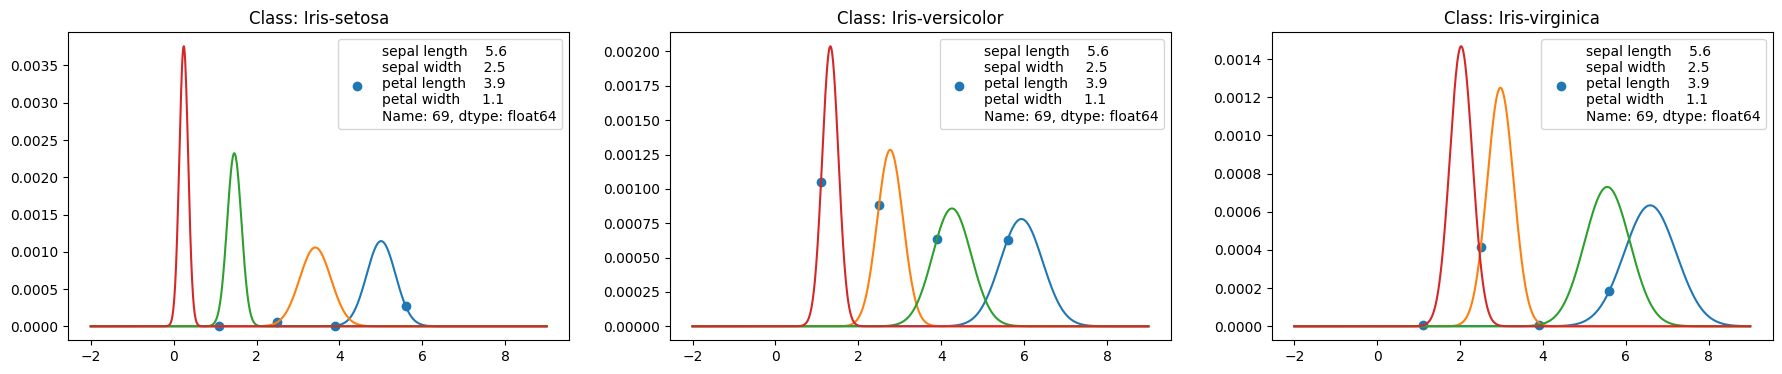

In [276]:
class_indices = list(y.groupby('class').groups.values())
number_line = np.linspace(-2, 9, 1000)
stacked_num_line = np.vstack([number_line, number_line, number_line, number_line]).transpose() # a number line for each class
random_sample = X.iloc[np.random.randint(0, len(X))]

fig, axes = plt.subplots(1, 3, figsize=(22, 4))
for _ in range(len(axes)):
    # Create and fit a prod_dist function
    probability_distribution = prob_dist(feature=X.iloc[class_indices[_]], thr=1e-3)
    
    # Plot
    axes[_].plot(number_line, probability_distribution(x=stacked_num_line))
    axes[_].scatter(random_sample, probability_distribution(x=np.array(random_sample)), label=str(random_sample))
    axes[_].set_title(f'Class: {y.iloc[class_indices[_]].iloc[0].values[0]}')
    axes[_].legend()
    
plt.show()

## Naive Bayes Classifier

In [277]:
class NaiveBayes:
    def __init__(self):
        self.classes = None
        self.indices = None
        self.class_conditionals = None
        self.class_probabilities = None
        self._probabilities = None
        self._fitted = False
        self._prob_dist = {}
    
    @property
    def probabilities(self):
        prob = pd.concat(self._probabilities, axis=1)
        prob.columns = self.classes
        return prob
    
    def _class_conditionals(self, x, c):
        func = self._prob_dist[c] 
        class_conditionals =  np.prod(func(x), axis=1) * self.class_probabilities[c]
        class_conditionals /= np.sum(class_conditionals) # compute conditional probability for each sample by dividing by the sum of samples
        return class_conditionals
        
    def predict(self, x):
        probabilities = []
        if not self._fitted:
            for i, (c, class_indices) in enumerate(zip(self.classes, self.indices)):
                # Create and fit a prob_dist function to this class  
                self._prob_dist[c] = prob_dist(feature=x.iloc[class_indices], thr=1e-3)   
                probabilities.append(self._class_conditionals(x=x, c=c)) # store probabilities
                
            self._fitted = True
        else:
            for i, c in enumerate(self.classes):
                probabilities.append(self._class_conditionals(x=x, c=c)) # store probabilities
                

        self._probabilities = probabilities
        return  [self.classes[_] for _ in np.argmax(pd.DataFrame(np.array(probabilities).transpose(), columns=self.classes), axis=1)]
    
    def fit(self, x: pd.DataFrame, y: pd.DataFrame):        
        if not isinstance(x, pd.DataFrame):
            x = pd.DataFrame(x)
            
        if isinstance(y, pd.DataFrame):
            y = pd.DataFrame(y)
        
        # Compute the prior for the class probabilities P(y)
        self.class_probabilities = y.value_counts()/len(y) 
        
        # Extract the classes
        self.classes = list(chain(*self.class_probabilities.index))
        
        # Extract indices
        self.indices = list(y.groupby(list(y.columns)).groups.values())
        
        return self.predict(x=x)

## Example

In [278]:
nb = NaiveBayes()
pred = nb.fit(x=X, y=y)
res = pd.concat([X, y, pd.DataFrame(pred), pd.DataFrame([int(t[0] == p) for t, p in zip(y.values, pred)])], axis=1)
res.columns = [*list(res.columns[:-3]), 'actual', 'pred', 'accurate']
print(f'accuracy: {res.accurate.mean()}')
res.head()

accuracy: 0.9466666666666667


,sepal length,sepal width,petal length,petal width,actual,pred,accurate
0,5.1,3.5,1.4,0.2,Iris-setosa,Iris-setosa,1
1,4.9,3.0,1.4,0.2,Iris-setosa,Iris-setosa,1
2,4.7,3.2,1.3,0.2,Iris-setosa,Iris-setosa,1
3,4.6,3.1,1.5,0.2,Iris-setosa,Iris-setosa,1
4,5.0,3.6,1.4,0.2,Iris-setosa,Iris-setosa,1


## Plots

In [279]:
def plot_result(features = (0, 2)):
    one, two = features
    # Assuming 'res' is your DataFrame and it's already defined
    x = res.iloc[:, one]
    y_ = res.iloc[:, two]
    predictions = res.iloc[:, -2] 
    labels = list(y.values) 
    classes = list(set(predictions))
    color_list = ['red', 'blue', 'green']
    c = {}
    # Plot each point individually
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
    for i in range(len(x)):
        color = color_list[classes.index(predictions[i])]
        color2 = color_list[classes.index(labels[i])]
        ax1.plot(x.iloc[i], y_.iloc[i], 'o', color=color)
        ax2.plot(x.iloc[i], y_.iloc[i], 'o', color=color2)
        
    ax1.set_xlabel(x.name)
    ax1.set_ylabel(y_.name)
    ax1.set_title('Prediction')
    
    ax2.set_xlabel(x.name)
    ax2.set_ylabel(y_.name)
    ax2.set_title('Label')
    plt.show()

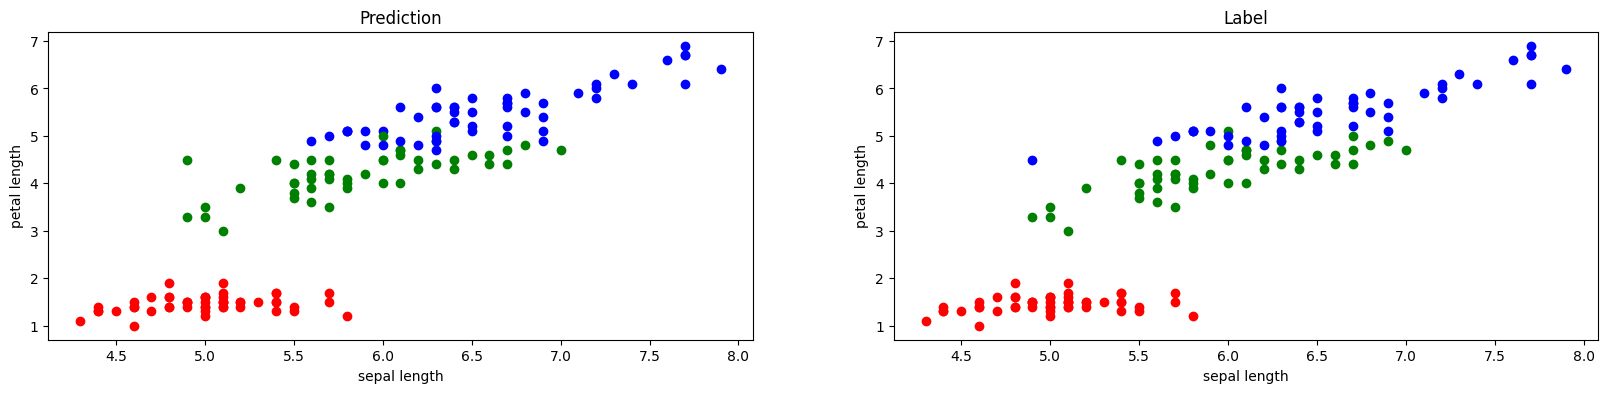

In [280]:
plot_result(features=(0, 2))